# Recommender Systems


## Explicit feedback

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Recommender systems are ubiquitous in digital world. Users encounter these systems as:

*  they see ‘Suggested Friends’ on Facebook,
* ‘Suggested Videos’ on YouTube,
* ‘Other Jobs for you’ on LinkedIn,
* ‘Suggested Products’ in any online shop.

There are two approaches through which recommendation system are designed:

1. Collaborative filtering

2. Content-based filtering


## Collaborative filtering

Today we are going to work with `GroupLens` $-$ [`MovieLens`](https://grouplens.org/datasets/movielens/) dataset which contains inforamtion about $27 000$ films and $138 000$ users with total amount of ratings about $20$ millions.

For simplicity we will use its shortened version with $9 000$ films, $700$ users, and $100 000$ ratings.
You may download it from [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

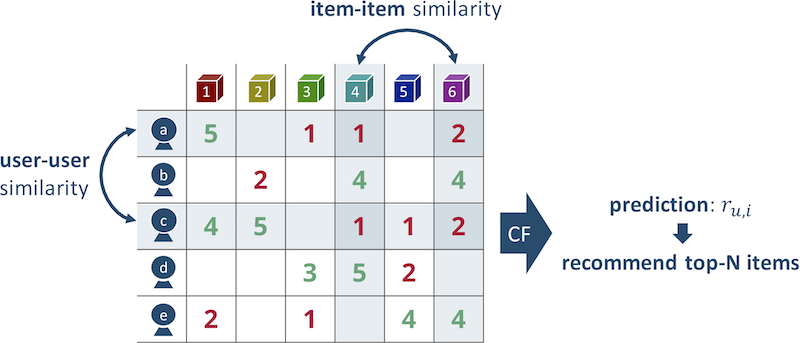

In [2]:
# для UNIX систем
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2022-06-06 14:40:43--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.59MB/s    in 0.2s    

2022-06-06 14:40:43 (4.59 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Data 

The archive contains several `csv` files. However, today we will work only with `ratings.csv`.


In [ ]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv', parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

### Metrics
For recommender systems several regression metrics can be used: `MSE`, `MAE` и `RMSE`.

Let's devide data into train and test. For this we put aside 20% of ratings.



In [ ]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

def train_test_split(X, ratio=0.2, user_col='userId', item_col='movieId',
                     rating_col='rating', time_col='timestamp'):
    X.sort_values(by=[time_col], inplace=True)

    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ratings)

  0%|          | 0/610 [00:00<?, ?it/s]

In [ ]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((80419, 2), 80419, (20417, 2), 20417)

## Task formalization 
There is a set of `users` ($U$) and a set of `items` ($I$). Some users have rated some films ($r_{ui}$). The goal is to predict unknown ratings.


### User-based model


**User-based model** belongs to collaborative filtering type of recommender systems. 


Main idea: **similar users typically like similar items**.

Thus, the algorithm can be formulated as follows:

    1) Calculate similarities between users in the dataset.
    
For this we may use Pearson's correlation or cosine similarity:

$$
    \textit{sim(u, v)} = \frac
    {\sum_i{\big((r_{ui} - \overline{r_u}) \times (r_{vi} - \overline{r_v})\big)}}
    {\sqrt{\sum_i{(r_{ui} - \overline{r_u})^2}} \times \sqrt{\sum_i{(r_{vi} - \overline{r_v})^2}}}
$$
    
    2) Combining ratings from other users, weighing them with precalculated similarity, predict the rating for the current user.


$$
    r_{ui} = \overline{r_u} + \frac
    {\sum_{v \in User_i}\big(\textit{sim(u, v)} \times (r_{vi} - \overline{r_v})\big)}
    {\sum_{v \in User_i}\textit{sim(u, v)}}
$$



In [ ]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='userId', item_col='movieId'):
        X = X.copy()
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y

        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        

        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        

        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        

        self.user_sim = cosine_similarity(self.user_ratings)
        
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        
        denominator = self.user_sim[self.user_pos[pr_user]].sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict(self, X, user_col='userId', item_col='movieId'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [ ]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ub.predict(X_test))))

start fitting...
start predicting...
rmse = 1.5766176670454974
CPU times: user 4.54 s, sys: 254 ms, total: 4.8 s
Wall time: 4.58 s


# Item-based model
**Item-based model** is similar to the user-based, but now we look for similar items, not users. 


Namely, the algorithm can be formulated as follows:


    1) Calculate similarities between items in the dataset (using Pearson's correlation or cosine similarity):
    
$$
    \textit{sim(i, j)} = \frac
    {\sum_u{\big((r_{ui} - \overline{r_i}) \times (r_{uj} - \overline{r_j})\big)}}
    {\sqrt{\sum_u{(r_{ui} - \overline{r_i})^2}} \times \sqrt{\sum_u{(r_{uj} - \overline{r_j})^2}}}
$$
    
    2) Given the ratings of other items, predict the rating for the current item, weighing other items with precalculated similarity


$$
    r_{ui} = \overline{r_i} + \frac
    {\sum_{j \in Item_u}\big(\textit{sim(i, j)} \times (r_{uj} - \overline{r_j})\big)}
    {\sum_{j \in Item_u}\textit{sim(i, j)}}
$$




In [ ]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='userId', item_col='movieId'):

        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        

        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        

        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        self.item_sim = cosine_similarity(self.item_ratings)
        
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        denominator = self.item_sim[self.item_pos[pr_item]].sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='userId', item_col='movieId'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [ ]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ib.predict(X_test))))

start fitting...
start predicting...
rmse = 1.656192129767858
CPU times: user 6.01 s, sys: 404 ms, total: 6.41 s
Wall time: 4.99 s


**Disadvantages:**
1. cold start problem,
2. difficulties with atypical users.

[Surprise library](http://surpriselib.com/) is "sklearn" for recommender systems.

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633696 sha256=8c466f08950914fbc2605b64172b1a19ddf39ffbca38abfd41bc0b8ac437b957
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = KNNBasic()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9772  0.9765  0.9825  0.9701  0.9859  0.9784  0.0054  
MAE (testset)     0.7717  0.7732  0.7736  0.7670  0.7797  0.7730  0.0040  
Fit time          0.37    0.41    0.41    0.39    0.39    0.39    0.02    
Test time         3.61    3.40    3.49    

{'fit_time': (0.3723156452178955,
  0.41250038146972656,
  0.4117696285247803,
  0.3885619640350342,
  0.38846373558044434),
 'test_mae': array([0.77172517, 0.77315718, 0.77361367, 0.76703108, 0.7796598 ]),
 'test_rmse': array([0.97722076, 0.97647101, 0.98245128, 0.97005657, 0.98593543]),
 'test_time': (3.606506586074829,
  3.3998820781707764,
  3.490633964538574,
  3.3782529830932617,
  3.358360528945923)}

In [ ]:
import pandas as pd

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate


# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)
df

,itemID,userID,rating
0,1,9,3
1,1,32,2
2,1,2,4
3,2,45,3
4,2,user_foo,1


In [ ]:
import pandas as pd

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate


# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(NormalPredictor(), data, cv=2)

{'fit_time': (0.0001380443572998047, 6.437301635742188e-05),
 'test_mae': array([1.14047986, 0.849153  ]),
 'test_rmse': array([1.23901376, 1.12034398]),
 'test_time': (0.00011706352233886719, 4.172325134277344e-05)}

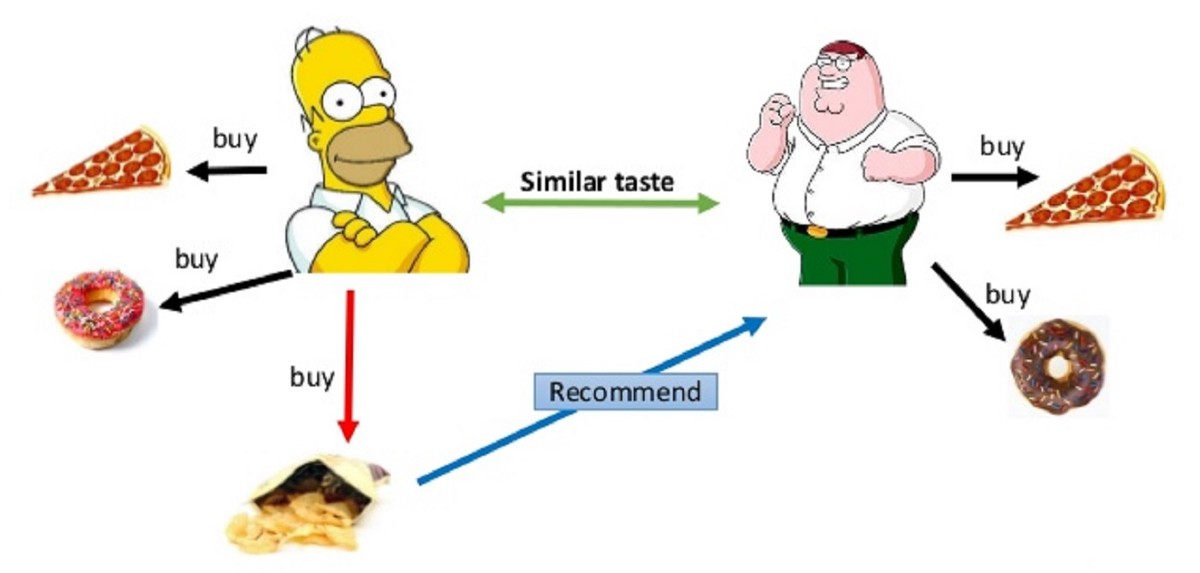